<a href="https://colab.research.google.com/github/mehdi-or/VT2PFC/blob/main/TRACE_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

Mounted at /content/gdrive


##finction to set the random see for reproducibility purposes

In [2]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # Numpy module
    torch.manual_seed(seed_value)  # PyTorch random number generator for CPU

    # If you are using CUDA
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

    # Additional configurations to enhance reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

##setting up the architecture of the network

In [3]:
class DATRACE(nn.Module):
    def __init__(self, VTC_dim, PFC_dim, hidden_dim, bottleneck_dim, num_classes):
        super(DATRACE, self).__init__()
        # Encoding layers for the VTC
        self.encoder_VTC = nn.Linear(VTC_dim, hidden_dim)

        # Shared bottleneck layer
        self.shared_bottleneck = nn.Linear(hidden_dim, bottleneck_dim)

        # Decoding layers for PFC
        self.decoder = nn.Linear(bottleneck_dim, hidden_dim)
        self.prediction_PFC = nn.Linear(hidden_dim, PFC_dim)

        # Classification layer attached to the shared bottleneck
        self.classifier = nn.Linear(bottleneck_dim, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x1):
        # Encoder VTC
        enocded_VTC = torch.tanh(self.encoder_VTC(x1))
        enocded_VTC = self.dropout(enocded_VTC)
        BN_shared = torch.tanh(self.shared_bottleneck(enocded_VTC))
        # Decoder PFC
        decoded = torch.tanh(self.decoder(BN_shared))
        predicted_PFC = self.prediction_PFC(decoded)

        # Classifier
        logits = self.classifier(BN_shared)
        probabilities = logits

        return predicted_PFC, probabilities
'''
# Example model instantiation
input_dim = 784 # e.g., for MNIST
output_dim =800
hidden_dim = 128
bottleneck_dim = 32
num_classes = 10 # e.g., for MNIST classification

model = DATRACE(VTC_dim=input_dim, PFC_dim=output_dim, hidden_dim=hidden_dim,
                                  bottleneck_dim=bottleneck_dim, num_classes=num_classes)
print(model)
'''

class CorrelationLoss(torch.nn.Module):
    def __init__(self):
        super(CorrelationLoss, self).__init__()

    def forward(self, x, y):
        # Ensure input is float for accurate mean and std calculations
        x = x.float()
        y = y.float()

        # Mean and standard deviation along the trials dimension
        x_mean = x.mean(dim=1, keepdim=True)
        y_mean = y.mean(dim=1, keepdim=True)
        x_std = x.std(dim=1, keepdim=True)
        y_std = y.std(dim=1, keepdim=True)

        # Covariance calculation
        covariance = ((x - x_mean) * (y - y_mean)).mean(dim=1)
        # Avoid division by zero
        eps = 1e-8
        correlation = covariance / (x_std * y_std + eps)

        # Negative mean correlation across all samples and features
        mean_correlation = correlation.mean()
        return -mean_correlation

##importing the data

In [4]:
def load_data_VTC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_VT_PETERS.hdf5', 'r') as hdf:
        data0 = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_vtc = np.array(data0)
        data_vtc = np.delete(data_vtc,np.where(~data_vtc.any(axis=0))[0],axis=1)
    return(data_vtc)

def load_data_PFC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_DLPFC_PETERS.hdf5', 'r') as hdf:
        data0_pfc = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_pfc = np.array(data0_pfc)
        data_pfc = np.delete(data_pfc,np.where(~data_pfc.any(axis=0))[0],axis=1)
    return(data_pfc)

def preprocessign (data, labels2categ, shuffle_index):
  data_train, data_test, y_categ_train, y_categ_test, map_train_index, map_test_index = train_test_split(data, labels2categ, shuffle_index, random_state=42)
  #scaler = StandardScaler()
  scaler = MinMaxScaler(feature_range=(-1,1))
  X_train = scaler.fit_transform(data_train)
  X_test = scaler.transform(data_test)
  return X_train, X_test, y_categ_train, y_categ_test, map_train_index, map_test_index

#setting the labels for pytorch is differen from keras
# the way it works is that we need to assign a number to each categorical class
unique_labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/unique_aranged.csv', header=None).values[:,1]
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/label.csv')['y'].values
label_to_index = {label: idx for idx, label in enumerate(unique_labels)} #mapping form label to its numeric value
index_to_label = {idx: label for label, idx in label_to_index.items()} #mapping from numeric label to the name of the label

#turning label file into its numeric values
numeric_labels = []
for label in labels:
  numeric_labels.append(label_to_index[label])

numeric_labels = np.array(numeric_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#converting all the numpy array inot pytorch tensor

VTC0 = load_data_VTC(37)
#VTC0 = np.random.normal(0,1, (3600, 2450)) #giving random noise as VTC data
PFC0 = load_data_PFC(37)
VTC_dim = VTC0.shape[1]
PFC_dim = PFC0.shape[1]
num_classes = len(np.unique(labels))
shuffle_index = np.arange(0,3600)
VTC_train, VTC_test, y_train, y_test, map_train_index, map_test_index = preprocessign(VTC0, numeric_labels, shuffle_index)
PFC_train, PFC_test, _, _, _, _ = preprocessign(PFC0, numeric_labels, shuffle_index)

VTC_tensor_train = torch.tensor(VTC_train, dtype=torch.float32).to(device)
VTC_tensor_test = torch.tensor(VTC_test, dtype=torch.float32).to(device)

PFC_tensor_train = torch.tensor(PFC_train, dtype=torch.float32).to(device)
PFC_tensor_test = torch.tensor(PFC_test, dtype=torch.float32).to(device)

y_tensor_train = torch.tensor(y_train)
y_tensor_test =torch.tensor(y_test)

train_dataset = TensorDataset(VTC_tensor_train, PFC_tensor_train, y_tensor_train)
test_dataset = TensorDataset(VTC_tensor_test, PFC_tensor_test, y_tensor_test)



##Training the network

In [ ]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

best_alpha = []
#alphas = [0, 0.05, 0.1, 0.3, 0.5] # Classifier weigth of the network
alphas = [0.0, 0.01, 0.1] # Classifier weigth of the network
# 3. Training loop
num_epochs = 300
for alpha in alphas:
  # 2. Define the model, optimizer, and loss functions
  model = DATRACE(VTC_dim=VTC_dim, PFC_dim=PFC_dim, hidden_dim=128, bottleneck_dim=32, num_classes=num_classes)
  optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
  #mse_loss_fn = nn.MSELoss()
  mse_loss_fn = nn.L1Loss()
  #mse_loss_fn = CorrelatonLoss()
  classification_loss_fn = nn.CrossEntropyLoss()
  # Track loss evolution
  train_loss_hist = []
  train_loss_PFC_hist = []
  train_loss_class_hist = []
  val_PFC_loss_hist = []
  val_loss_history = []
  for epoch in range(num_epochs):
      set_seed(42 + epoch)
      model.train()
      train_loss = 0
      predicted_loss_PFC = 0
      classification_loss = 0
      for input_VTC, input_PFC, labels in train_loader:
          optimizer.zero_grad()
          predicted_PFC, probabilities = model(input_VTC)

          # Calculate losses
          predicted_loss_PFC0 = mse_loss_fn(predicted_PFC, input_PFC)
          classification_loss0 = classification_loss_fn(probabilities, labels)

          # Total loss
          total_loss = predicted_loss_PFC0 + alpha*classification_loss0

          # Backpropagation and optimizer step
          total_loss.backward()
          optimizer.step()
          predicted_loss_PFC += predicted_loss_PFC0.item()
          classification_loss += classification_loss0.item()
          train_loss += total_loss.item()
      predicted_loss_PFC /= len(train_loader)
      classification_loss /= len(train_loader)
      train_loss /= len(train_loader)

      train_loss_PFC_hist.append(predicted_loss_PFC)
      train_loss_class_hist.append(classification_loss)
      train_loss_hist.append(train_loss)


      # Validation
      model.eval()
      val_loss = 0
      val_PFC_loss = 0
      with torch.no_grad():
          for input_VTC, input_PFC, labels in test_loader:
              reconstructed, probabilities = model(input_VTC)
              PFC_loss = mse_loss_fn(reconstructed, input_PFC)
              classification_loss = classification_loss_fn(probabilities, labels)
              loss = PFC_loss + alpha*classification_loss
              val_PFC_loss += PFC_loss.item()
              val_loss += loss.item()

      val_PFC_loss /= len(test_loader)
      val_loss /= len(test_loader)
      val_PFC_loss_hist.append(val_PFC_loss)
      val_loss_history.append(val_loss)

      if (epoch+1)%(num_epochs/10)==0:
        print(f"Epoch {epoch+1}/{num_epochs} completed for alpha={alpha}.")
  best_alpha.append(val_PFC_loss_hist)

# 4. Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(train_loss_PFC_hist, label='Training PFC')
plt.plot(train_loss_class_hist, label='Training classifier')
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.show()


## function for training the model

Epoch 30/300 completed for alpha=0.1.
Epoch 60/300 completed for alpha=0.1.
Epoch 90/300 completed for alpha=0.1.
Epoch 120/300 completed for alpha=0.1.
Epoch 150/300 completed for alpha=0.1.
Epoch 180/300 completed for alpha=0.1.
Epoch 210/300 completed for alpha=0.1.
Epoch 240/300 completed for alpha=0.1.
Epoch 270/300 completed for alpha=0.1.
Epoch 300/300 completed for alpha=0.1.


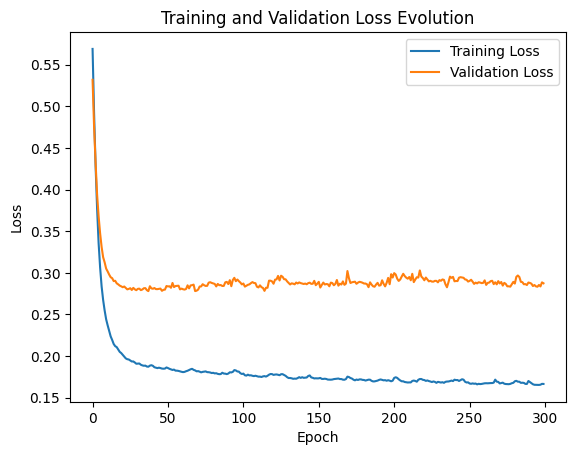

In [21]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
alpha = 0.1 # Classifier weigth of the network
# 3. Training loop
num_epochs = 30
# 2. Define the model, optimizer, and loss functions
model = DATRACE(VTC_dim=VTC_dim, PFC_dim=PFC_dim, hidden_dim=128, bottleneck_dim=32, num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
#mse_loss_fn = nn.MSELoss()
mse_loss_fn = nn.L1Loss()
#mse_loss_fn = CorrelatonLoss()
classification_loss_fn = nn.CrossEntropyLoss()


def trainAndval (train_loader, test_loader, num_epochs=300, alpha=0.1):
  train_loss_PFC_hist = []
  train_loss_class_hist = []
  val_PFC_loss_hist = []
  train_loss_hist = []
  val_loss_hist = []
  for epoch in range(num_epochs):
      train_loss = 0
      predicted_loss_PFC = 0
      classification_loss = 0
      set_seed(42 + epoch)
      model.train()
      for input_VTC, input_PFC, labels in train_loader:
          optimizer.zero_grad()
          predicted_PFC, probabilities = model(input_VTC)
          # Calculate losses
          predicted_loss_PFC0 = mse_loss_fn(predicted_PFC, input_PFC)
          classification_loss0 = classification_loss_fn(probabilities, labels)
          # Total loss
          total_loss = predicted_loss_PFC0 + alpha*classification_loss0
          # Backpropagation and optimizer step
          total_loss.backward()
          optimizer.step()
          predicted_loss_PFC += predicted_loss_PFC0.item()
          classification_loss += classification_loss0.item()
          train_loss += total_loss.item()
      predicted_loss_PFC /= len(train_loader)
      classification_loss /= len(train_loader)
      train_loss /= len(train_loader)
      train_loss_PFC_hist.append(predicted_loss_PFC)
      train_loss_class_hist.append(classification_loss)
      train_loss_hist.append(train_loss)

      # Validation
      model.eval()
      val_loss = 0
      val_PFC_loss = 0
      with torch.no_grad():
          for input_VTC, input_PFC, labels in test_loader:
              reconstructed, probabilities = model(input_VTC)
              PFC_loss = mse_loss_fn(reconstructed, input_PFC)
              classification_loss = classification_loss_fn(probabilities, labels)
              loss = PFC_loss + alpha*classification_loss
              val_PFC_loss += PFC_loss.item()
              val_loss += loss.item()

      val_PFC_loss /= len(test_loader)
      val_loss /= len(test_loader)
      val_PFC_loss_hist.append(val_PFC_loss)
      val_loss_hist.append(val_loss)

      if (epoch+1)%(num_epochs/10)==0:
        print(f"Epoch {epoch+1}/{num_epochs} completed for alpha={alpha}.")
  return model, train_loss_hist, val_loss_hist

model, train_loss_hist, val_loss_hist = trainAndval (train_loader, test_loader, num_epochs=300, alpha=0.1)

'''
# 4. Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(train_loss_PFC_hist, label='Training PFC')
plt.plot(train_loss_class_hist, label='Training classifier')
'''
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.show()

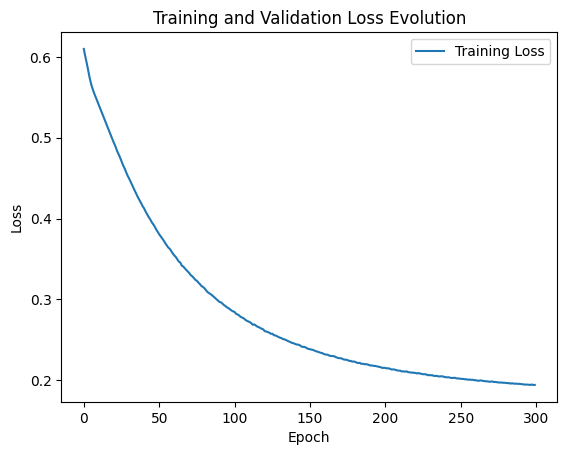

In [20]:
plt.plot(train_loss_hist, label='Training Loss')
#plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.show()

##plotting the loss functions

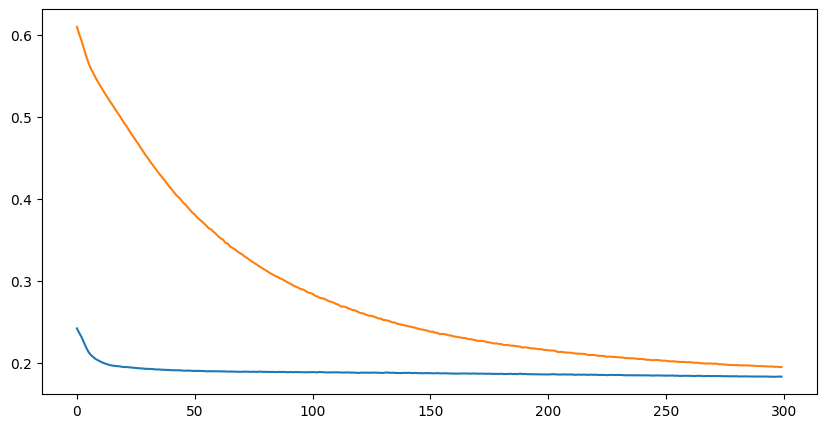

In [ ]:

# 4. Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(train_loss_PFC_hist[-300:], label='Training PFC')
#plt.plot(train_loss_class_hist, label='Training classifier')
plt.plot(train_loss_hist[-300:], label='Training Loss')
#plt.plot(val_loss_history, label='Validation Loss')

[0.23690764605998993, 0.230057950814565, 0.2219595472017924, 0.21439380844434103, 0.20883959631125132, 0.20513800879319508, 0.20243328313032785, 0.20002850393454233, 0.19774055381615957, 0.19570472141106923, 0.19400257766246795, 0.19259505073229471, 0.19143095811208088, 0.1904699852069219, 0.18960557679335277, 0.18887531061967214, 0.18821276227633157, 0.18755146662394206, 0.18693637053171794, 0.18635567128658295, 0.18580369353294374, 0.18527271449565888, 0.18476083079973857, 0.18432350258032482, 0.1838514029979706, 0.18344466686248778, 0.18303694029649098, 0.1826567679643631, 0.18229278127352397, 0.18192848563194275, 0.18156939844290415, 0.18119872013727825, 0.18086891571680705, 0.18052612543106078, 0.18018421133359272, 0.17986890375614167, 0.17952504754066467, 0.17921907603740692, 0.17893122931321462, 0.17861454586188, 0.17827779153982798, 0.17801943520704905, 0.17773447831471761, 0.17748331725597383, 0.17719517052173614, 0.17694810728232066, 0.17671853999296824, 0.1764609734217326, 0

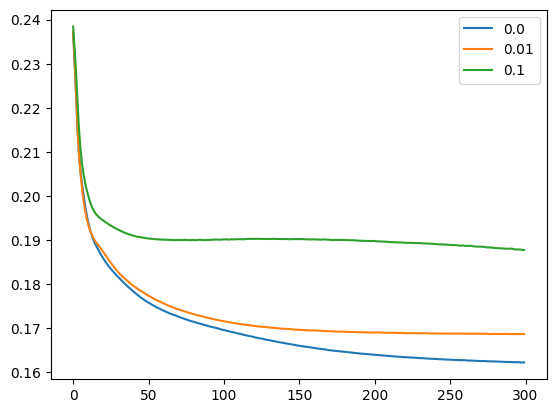

In [ ]:
for i, loss in enumerate(best_alpha):
  print(loss)
  plt.plot(loss[-300:], label=alphas[i])
plt.legend()